In [1]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

import wandb
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

## config

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]

# seed
seed_everything(SEED)

Global seed set to 1996


1996

In [3]:
EXP_NAME

'exp008'

In [4]:
!wandb login 1bb2d0449c11d8b987e25c38b9d8dda176310fb6

wandb: Appending key for api.wandb.ai to your netrc file: /home/kuzira/.netrc


## read data

In [5]:
# waypointを補正したdataset
root_dir = Path('../../input/')
with open(root_dir/'kuto_wifi_dataset_v2/train_all.pkl', 'rb') as f:
  train_df = pickle.load(f)

with open(root_dir/'kuto_wifi_dataset_v2/test_all.pkl', 'rb') as f:
  test_df = pickle.load(f)

sub = pd.read_csv(root_dir/'indoor-location-navigation/sample_submission.csv', index_col=0)

In [6]:
train_df

,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9,...,timestamp,x,y,floor,floor_str,path,time_diff,wifi_x,wifi_y,site_id
0,ffe684dfd25a52b046e3108a3f70df46001425f0,97e4a381c3a02ed3151bbf41b8fc1fe5815f5387,5b71ef95e53358c558b78bf3fb152d793729bc8d,2f85d197aec7bfddfee3f53ae9e1b6ed1fc56e92,4328f33869766d0f77a9299441556338e4d8a2b9,df41c761b69993669d4eb875b4474ec44d2372ed,7dc49736770ee9073043134656c89a17529f882f,5a1a7a8496e5f8b88db082de0b412e447e01fd0b,463d0cfe3748eb70524138ed970f03375e8d1030,79179095e63e2b0431e85e3e33b02d95bb135c2e,...,1571625311855,68.064926,241.94000,0,F1,5dad1ca1dc3e2c0006606c3f,1952,66.823935,241.889369,5da958dd46f8266d0737457b
1,97e4a381c3a02ed3151bbf41b8fc1fe5815f5387,5b71ef95e53358c558b78bf3fb152d793729bc8d,cb8f53745c342e2bfd0bf77a5fd8cac6cf303945,ffe684dfd25a52b046e3108a3f70df46001425f0,6b769b9eeb24ff287e6a53736cc7c013d5902901,7dc49736770ee9073043134656c89a17529f882f,3fef087dd272ab07981a60c9cbf6f27460d1364e,5a1a7a8496e5f8b88db082de0b412e447e01fd0b,df41c761b69993669d4eb875b4474ec44d2372ed,d8b1ff62702e02106553be91dc22a0dcf0e780a7,...,1571625311855,68.064926,241.94000,0,F1,5dad1ca1dc3e2c0006606c3f,3900,65.582943,241.838738,5da958dd46f8266d0737457b
2,97e4a381c3a02ed3151bbf41b8fc1fe5815f5387,6b769b9eeb24ff287e6a53736cc7c013d5902901,cb8f53745c342e2bfd0bf77a5fd8cac6cf303945,4328f33869766d0f77a9299441556338e4d8a2b9,3fef087dd272ab07981a60c9cbf6f27460d1364e,5a1a7a8496e5f8b88db082de0b412e447e01fd0b,7dc49736770ee9073043134656c89a17529f882f,df41c761b69993669d4eb875b4474ec44d2372ed,5b71ef95e53358c558b78bf3fb152d793729bc8d,2f85d197aec7bfddfee3f53ae9e1b6ed1fc56e92,...,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,-2385,64.341952,241.788107,5da958dd46f8266d0737457b
3,97e4a381c3a02ed3151bbf41b8fc1fe5815f5387,4328f33869766d0f77a9299441556338e4d8a2b9,3fef087dd272ab07981a60c9cbf6f27460d1364e,5a1a7a8496e5f8b88db082de0b412e447e01fd0b,5d82171d37c5296bcaed8c02745540b491d8a284,471740ef5065943b791f277ada358f9ffc011645,2f85d197aec7bfddfee3f53ae9e1b6ed1fc56e92,afe423c7bc0641d63c95e232ffd65cae3be95351,df41c761b69993669d4eb875b4474ec44d2372ed,5b71ef95e53358c558b78bf3fb152d793729bc8d,...,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,-427,62.480465,241.712160,5da958dd46f8266d0737457b
4,97e4a381c3a02ed3151bbf41b8fc1fe5815f5387,4328f33869766d0f77a9299441556338e4d8a2b9,5a1a7a8496e5f8b88db082de0b412e447e01fd0b,cb8f53745c342e2bfd0bf77a5fd8cac6cf303945,6b769b9eeb24ff287e6a53736cc7c013d5902901,5d82171d37c5296bcaed8c02745540b491d8a284,5b71ef95e53358c558b78bf3fb152d793729bc8d,df41c761b69993669d4eb875b4474ec44d2372ed,2f85d197aec7bfddfee3f53ae9e1b6ed1fc56e92,afe423c7bc0641d63c95e232ffd65cae3be95351,...,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,1528,62.893219,240.715162,5da958dd46f8266d0737457b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,993a56b32432fb19bfb4461a0e1a2ead9bcf192f,773cde25cb4e9fd90b11603abd5bf84d83b340e6,19647ac7bb55a673554aa08cafb3b096aac7f32c,a4a410696cb935d542d62afd8e8090dbbc341a16,fc27c0656fc13157bb2f58543d51e8ee972fdf66,c7d8359344120911f8550487f282c241d93c4750,26b22cce3b7694a7d765d9cf329b9065f3fb3a3c,827530050f580378b7aa53fb292dfb8a12b775e1,d64eeb8d997e8d87203479556bbb9efaf7e487fd,22a52f1717436ee378dc44b6d707a3816a65b5e4,...,1573822164854,12.662716,100.47756,1,F2,5dce9eea5516ad00065f04a7,447,12.662716,100.477560,5d27099f03f801723c32511d
258121,773cde25cb4e9fd90b11603abd5bf84d83b340e6,993a56b32432fb19bfb4461a0e1a2ead9bcf192f,19647ac7bb55a673554aa08cafb3b096aac7f32c,fc27c0656fc13157bb2f58543d51e8ee972fdf66,a4a410696cb935d542d62afd8e8090dbbc341a16,827530050f580378b7aa53fb292dfb8a12b775e1,c7d8359344120911f8550487f282c241d93c4750,d64eeb8d997e8d87203479556bbb9efaf7e487fd,b08a1d79d6d4bb2ca71336f7e995c7aa1342aa1f,26b22cce3b7694a7d765d9cf329b9065f3fb3a3c,...,1573822164854,12.662716,100.47756,1,F2,5dce9eea5516ad00065f04a7,2393,11.041773,102.698110,5d27099f03f801723c32511d
258122,993a56b32432fb19bfb4461a0e

In [7]:
train_df['x'].nunique(), train_df['wifi_x'].nunique()

(25336, 231094)

## time_diffの前処理
0~3000sのものはwifi_x,wifi_yを使用  
-1000s~0sのものはもともとのx.yを使用

In [8]:
# POSI_DIFF = 4000  # i番目のwaypointを基準に算出したwifi waypointのうち基準のtimestampの直近3sを信頼できるデータとして残す
# NEGA_DIFF = -100000  # i番目のwaypointを基準に算出したwifi waypointのうちi+1番目のwaypointに近いものにはi+1のwaypointを座標として与える

# train_df.loc[(NEGA_DIFF < train_df['time_diff']) & (train_df['time_diff'] <= 0), 'wifi_x'] = train_df.loc[(NEGA_DIFF< train_df['time_diff']) & (train_df['time_diff'] <= 0), 'x']
# train_df.loc[(NEGA_DIFF < train_df['time_diff']) & (train_df['time_diff'] <= 0), 'wifi_y'] = train_df.loc[(NEGA_DIFF < train_df['time_diff']) & (train_df['time_diff'] <= 0), 'y']
# train_df = train_df[(NEGA_DIFF < train_df['time_diff']) & (train_df['time_diff'] < POSI_DIFF)].reset_index(drop=True)
# train_df

BSSIDとRSSIは100ずつ存在しているけど全てが必要なわけではないみたい  
ここでは20だけ取り出している。

In [9]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]

bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない


In [10]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids = list(set(wifi_bssids))
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 41286
BSSID TYPES(test): 28592
BSSID TYPES(all): 41300


## preprocessing

In [11]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])

ss = StandardScaler()
ss.fit(train_df.loc[:,RSSI_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
    output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
        output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？ embeddingのpadding用のダミー変数？

    # site_idのLE
    output_df['site_id_str'] = input_df['site_id'].copy()
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
    # output_df.loc[:,RSSI_FEATS] = ss.transform(output_df.loc[:,RSSI_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

    

In [12]:
site_count = len(train['site_id'].unique())
site_count

24

In [13]:
train.iloc[:, -15:]

,rssi_96,rssi_97,rssi_98,rssi_99,timestamp,x,y,floor,floor_str,path,time_diff,wifi_x,wifi_y,site_id,site_id_str
0,-84,-84,-85,-85,1571625311855,68.064926,241.94000,0,F1,5dad1ca1dc3e2c0006606c3f,1952,66.823935,241.889369,21,5da958dd46f8266d0737457b
1,-84,-84,-85,-85,1571625311855,68.064926,241.94000,0,F1,5dad1ca1dc3e2c0006606c3f,3900,65.582943,241.838738,21,5da958dd46f8266d0737457b
2,-83,-83,-83,-83,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,-2385,64.341952,241.788107,21,5da958dd46f8266d0737457b
3,-83,-83,-83,-83,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,-427,62.480465,241.712160,21,5da958dd46f8266d0737457b
4,-83,-83,-83,-83,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,1528,62.893219,240.715162,21,5da958dd46f8266d0737457b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,-79,-80,-80,-80,1573822164854,12.662716,100.47756,1,F2,5dce9eea5516ad00065f04a7,447,12.662716,100.477560,5,5d27099f03f801723c32511d
258121,-80,-80,-81,-81,1573822164854,12.662716,100.47756,1,F2,5dce9eea5516ad00065f04a7,2393,11.041773,102.698110,5,5d27099f03f801723c32511d
258122,-80,-80,-80,-80,1573822173051,7.799886,107.13921,1,F2,5dce9eea5516ad00065f04a7,-3876,9.961144,104.178477,5,5d27099f03f801723c32511d
258123,-81,-81,-81,-81,1573822173051,7.799886,107.13921,1,F2,5dce9eea5516ad00065f04a7,-1946,8.880515,105.658843,5,5d27099f03f801723c32511d


## PyTorch model
- embedding layerが重要  

In [14]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(np.float32)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            # self.xy = df[['x', 'y']].values.astype(np.float32)
            self.xy = df[['wifi_x', 'wifi_y']].values.astype(np.float32)  # wifiにより補正したx,yを使用
            self.floor = df['floor'].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        feature = {
            'BSSID_FEATS':self.bssid_feats[idx],
            'RSSI_FEATS':self.rssi_feats[idx],
            'site_id':self.site_id[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'floor':self.floor[idx]
            }
        else:
            target = {}
        return feature, target

In [15]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, wifi_bssids_size, site_count=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.embedding_layer1 = nn.Sequential(
            nn.Embedding(wifi_bssids_size, embedding_dim),
            nn.Flatten(start_dim=-2)            
        )
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す
        self.embedding_layer2 = nn.Sequential(
            nn.Embedding(site_count, 2),
            nn.Flatten(start_dim=-1)           
        )

        # rssi
        # 次元を64倍に線形変換
        self.linear_layer1 = nn.Sequential(
            nn.BatchNorm1d(NUM_FEATS),
            nn.Linear(NUM_FEATS, NUM_FEATS * embedding_dim),
            nn.ReLU()
        )
        
        # bssid, site, rssiの出力size
        feature_size = 2 + (2 * NUM_FEATS * embedding_dim)
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(feature_size),
            nn.Dropout(0.3),
            nn.Linear(feature_size, 256),
            nn.ReLU()
        )

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        # self.fc_x = nn.Linear(16, 1)
        # self.fc_y = nn.Linear(16, 1)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_bssid = self.embedding_layer1(x['BSSID_FEATS'])
        x_site_id = self.embedding_layer2(x['site_id'])
        x_rssi = self.linear_layer1(x['RSSI_FEATS'])
        x = torch.cat([x_bssid, x_site_id, x_rssi], dim=-1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        # x_ = self.fc_x(x).view(-1)
        # y_ = self.fc_y(x).view(-1)
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        # return {"x":x_, "y":y_, "floor":floor} 
        return {"xy": xy, "floor": floor}

In [16]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [17]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [18]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["xy"])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["xy"])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)
        
        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [20]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [21]:
oofs = []  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = model_selection.StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = model_selection.GroupKFold(n_splits=N_SPLITS)
# 今回はtargetを均等に分ける必要はなくpathが均等に分かれればいいのでskf.split()にpathを与えている。
for fold, (trn_idx, val_idx) in enumerate(gkf.split(train.loc[:, 'path'], groups=train.loc[:, 'path'])):
    # 指定したfoldのみループを回す
    if fold not in USE_FOLDS:
        continue

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_df = train.loc[trn_idx, BSSID_FEATS + RSSI_FEATS + ['site_id', 'wifi_x','wifi_y','floor']].reset_index(drop=True)
    val_df = train.loc[val_idx, BSSID_FEATS + RSSI_FEATS + ['site_id', 'wifi_x','wifi_y','floor']].reset_index(drop=True)

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)

    # model
    model = LSTMModel(wifi_bssids_size+1, site_count)  # +1としているのはLEを1スタートで始めているため
    model_name = model.__class__.__name__

    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=f"../../model/{EXP_NAME}",
        verbose=False,
        filename=f'{model_name}-{fold}')
    
    if MODEL_SAVE:
        callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=10,
        verbose=False,
        mode='min')
    callbacks.append(early_stop_callback)

    # loggers
    RUN_NAME = EXP_NAME + "_" + EXP_MESSAGE
    wandb.init(project='indoor', notes=NOTES, entity='kuto5046', group=RUN_NAME)
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb_config.LB = None
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    # pretrained flag
    if PRETRAINED:
        ckpt = torch.load(PRETRAINED_PATH + f'{model_name}-{fold}.ckpt')
        learner.load_state_dict(ckpt['state_dict'])

    if not ONLY_PRED:
        trainer = pl.Trainer(
            logger=loggers, 
            callbacks=callbacks,
            max_epochs=MAX_EPOCHS,
            gpus=[0],
            fast_dev_run=DEBUG,
            deterministic=True,
            # precision=16,
            progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
            )

        trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()  
    oof_df = train.loc[val_idx, ['timestamp', 'x', 'y', 'site_id','site_id_str', 'wifi_x','wifi_y', 'floor', 'floor_str', 'path', 'time_diff']].reset_index(drop=True)
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oof_df["oof_x"] = oof_x
    oof_df["oof_y"] = oof_y
    oof_df["oof_floor"] = oof_f
    oofs.append(oof_df)
    
    val_score = mean_position_error(
        oof_df["oof_x"].values, oof_df["oof_y"].values, 0,
        oof_df['wifi_x'].values, oof_df['wifi_y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############n

    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    test_preds.to_csv(f'{EXP_NAME}_fold{fold}.csv', index=False)
    predictions.append(test_preds)
    wandb.finish()

Fold 0
/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kuto5046 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 0: mean position error 7.710968541326397


Fold 1
wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 1: mean position error 7.722838655325648


Fold 2
wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 2: mean position error 7.369896543694032


Fold 3
wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 3: mean position error 8.058767830670824


Fold 4
wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 4: mean position error 7.71283324302871


In [22]:
if len(USE_FOLDS) > 1:
    oofs_df = pd.concat(oofs)
else:
    oofs_df = oofs[0]

oofs_df['site_path_timestamp'] = oofs_df['site_id_str'].astype(str) + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df = oofs_df.sort_values('site_path_timestamp').reset_index(drop=True)
oofs_df.to_csv("oof.csv", index=False)
oofs_df

,timestamp,x,y,site_id,site_id_str,wifi_x,wifi_y,floor,floor_str,path,time_diff,oof_x,oof_y,oof_floor,site_path_timestamp
0,1561368762838,78.21819,38.999737,0,5a0546857ecc773753327266,77.890465,37.584921,2,F3,5d10a1669c50c70008fe8977,1969,84.865143,39.419571,0.207957,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
1,1561368762838,78.21819,38.999737,0,5a0546857ecc773753327266,77.562740,36.170105,2,F3,5d10a1669c50c70008fe8977,3966,87.870216,33.456242,0.206626,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
2,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,77.235015,34.755289,2,F3,5d10a1669c50c70008fe8977,-5250,82.229469,30.581415,0.211186,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
3,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,77.202679,21.519628,2,F3,5d10a1669c50c70008fe8977,8838,82.887291,28.168413,0.208902,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
4,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,76.991381,23.517675,2,F3,5d10a1669c50c70008fe8977,6812,80.341606,22.184681,0.212189,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,1574420742502,193.20488,108.001520,23,5dc8cea7659e181adb076a3f,197.825134,107.932187,-1,B1,5dd7c119c5b77e0006b16b99,4790,199.136230,104.263153,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
258121,1574420742502,193.20488,108.001520,23,5dc8cea7659e181adb076a3f,194.128931,107.987653,-1,B1,5dd7c119c5b77e0006b16b99,1006,201.388168,103.995300,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
258122,1574420753754,204.29349,107.835120,23,5dc8cea7659e181adb076a3f,199.673236,107.904453,-1,B1,5dd7c119c5b77e0006b16b99,-4550,199.976761,103.671677,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
258123,1574420753754,204.29349,107.835120,23,5dc8cea7659e181adb076a3f,201.521337,107.876720,-1,B1,5dd7c119c5b77e0006b16b99,-2662,201.535706,104.701302,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...


In [23]:
if len(USE_FOLDS) > 1:
    # foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
    sub = pd.concat(predictions).groupby('site_path_timestamp').mean().reindex(sub.index)
else:
    sub = predictions[0].reindex(sub.index)
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,87.954796,102.605637
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,84.130959,102.008942
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,86.090317,104.619865
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,87.595718,105.741379
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,86.149513,105.548729
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,0,214.097397,90.171814
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,0,209.983994,99.197472
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,0,205.807724,105.314880


In [24]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv(root_dir / 'simple-99-accurate-floor-model/submission.csv')
sub['floor'] = simple_accurate_99['floor'].values
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,87.954796,102.605637
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,84.130959,102.008942
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,86.090317,104.619865
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,87.595718,105.741379
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,86.149513,105.548729
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,214.097397,90.171814
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,209.983994,99.197472
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,205.807724,105.314880


In [25]:
# waypoint補正前のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['x'], oofs_df['y'], 0
    )
print(f"CV:{oof_score}")

CV:8.217586046438461


In [26]:
# waypoint補正後のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['wifi_x'], oofs_df['wifi_y'], 0
    )
print(f"CV:{oof_score}")

CV:7.7150609628091225


In [27]:
def calc_metrics_site(x_pred, y_pred, f_pred, x_true, y_true, f_true, site_arr):
    '''
    site_arrは、intじゃなくて、"B1", "F2"みたいな感じで入力
    site_arr = le_site.inverse_transform(df_train.site_id)
    '''
    site_arr = np.asarray(site_arr)
    site_unique = sorted(np.unique(site_arr))
    score_list = []
    n_sample = []
    for site in site_unique:
        logics = site_arr == site
        x_pred_, y_pred_, f_pred_ = x_pred[logics], y_pred[logics], f_pred[logics]
        x_true_, y_true_, f_true_, = x_true[logics], y_true[logics], f_true[logics]
        len_x = len(x_pred_)
        
        intermediate = np.sqrt(np.power(x_pred_-x_true_, 2) + np.power(y_pred_-y_true_, 2)) + 15 * np.abs(f_pred_-f_true_)
        
        score_list.append(intermediate.sum()/len_x)
        n_sample.append(len_x)
    
    df_result = pd.DataFrame({
        'site': site_unique,
        'n_sample': n_sample,
        'score': score_list,
    })
    return df_result

import pytablewriter
def site_eval_report(df_result_site):
    df_result_site.insert(loc=0, column='No', value=df_result_site.index)
    writer = pytablewriter.MarkdownTableWriter()
    writer.from_dataframe(df_result_site)
    writer.write_table()

In [68]:
x_pred = oofs_df["oof_x"]
y_pred = oofs_df["oof_y"]
f_pred = oofs_df["floor"]  # 正解を与える
x_true = oofs_df["wifi_x"]
y_true = oofs_df["wifi_y"]
f_true = oofs_df["floor"]
site_arr = oofs_df["site_id_str"]
df_result_site1 = calc_metrics_site(x_pred, y_pred, f_pred, x_true, y_true, f_true, site_arr)
df_result_site1.style.bar(subset=['n_sample', 'score'], color=['teal'])

,site,n_sample,score
0,5a0546857ecc773753327266,9296,5.155268
1,5c3c44b80379370013e0fd2b,9737,8.013753
2,5d27075f03f801723c2e360f,23666,7.111779
3,5d27096c03f801723c31e5e0,9100,4.682105
4,5d27097f03f801723c320d97,10507,10.757988
5,5d27099f03f801723c32511d,4251,6.952029
6,5d2709a003f801723c3251bf,3940,5.389814
7,5d2709b303f801723c327472,15358,5.844538
8,5d2709bb03f801723c32852c,17203,9.210884
9,5d2709c303f801723c3299ee,10083,6.367946


In [69]:
site_eval_report(df_result_site1)

|No |          site          |n_sample|score |
|--:|------------------------|-------:|-----:|
|  0|5a0546857ecc773753327266|    9296| 5.155|
|  1|5c3c44b80379370013e0fd2b|    9737| 8.014|
|  2|5d27075f03f801723c2e360f|   23666| 7.112|
|  3|5d27096c03f801723c31e5e0|    9100| 4.682|
|  4|5d27097f03f801723c320d97|   10507|10.758|
|  5|5d27099f03f801723c32511d|    4251| 6.952|
|  6|5d2709a003f801723c3251bf|    3940| 5.390|
|  7|5d2709b303f801723c327472|   15358| 5.845|
|  8|5d2709bb03f801723c32852c|   17203| 9.211|
|  9|5d2709c303f801723c3299ee|   10083| 6.368|
| 10|5d2709d403f801723c32bd39|   10027| 7.982|
| 11|5d2709e003f801723c32d896|   11042| 8.933|
| 12|5da138274db8ce0c98bbd3d2|    2662| 7.047|
| 13|5da1382d4db8ce0c98bbe92e|    8999| 7.467|
| 14|5da138314db8ce0c98bbf3a0|    9012| 4.484|
| 15|5da138364db8ce0c98bc00f1|    2767| 4.350|
| 16|5da1383b4db8ce0c98bc11ab|   13196| 9.978|
| 17|5da138754db8ce0c98bca82f|    7188| 7.655|
| 18|5da138764db8ce0c98bcaa46|    9420| 7.069|
| 19|5da1389e

In [29]:
# sub.to_csv(EXP_NAME + '_sub.csv')

## 後処理

## cost minimaization

In [30]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm
import sys
sys.path.append('../../')
from src.io_f import read_data_file
from src import compute_f

In [31]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions
    
def correct_path(args):
    path, path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{root_dir}/indoor-location-navigation/test/{path}.txt')
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

def correct_path_train(args):
    #print(args)
    (site_id, path, floor), path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{root_dir}/indoor-location-navigation/train/{site_id}/{floor}/{path}.txt')
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]

    try:
        delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)
    except:
        return pd.DataFrame({
            'site_path_timestamp' : path_df['site_path_timestamp'],
            'floor' : path_df['floor'],
            'x' : path_df['x'].to_numpy(),
            'y' : path_df['y'].to_numpy()
        })
    

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)


    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [32]:
%%time

oofs_df = oofs_df.rename(columns={'x':'target_x', 'y':'target_y', 'oof_x':'x', 'oof_y':'y'})
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path_train, oofs_df.groupby(['site_id_str', 'path', 'floor_str']))
    dfs = tqdm(dfs)
    dfs = list(dfs)

oof_post_process = pd.concat(dfs).sort_index()
oofs_df['oof_min_x'] = oof_post_process['x']
oofs_df['oof_min_y'] = oof_post_process['y']

# 元に戻す
oofs_df = oofs_df.rename(columns={'x':'oof_x', 'y':'oof_y'})
oofs_df

10852it [03:49, 47.19it/s]
CPU times: user 41.5 s, sys: 8.24 s, total: 49.7 s
Wall time: 3min 52s


,timestamp,target_x,target_y,site_id,site_id_str,wifi_x,wifi_y,floor,floor_str,path,time_diff,oof_x,oof_y,oof_floor,site_path_timestamp,oof_min_x,oof_min_y
0,1561368762838,78.21819,38.999737,0,5a0546857ecc773753327266,77.890465,37.584921,2,F3,5d10a1669c50c70008fe8977,1969,84.865143,39.419571,0.207957,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.193822,35.990409
1,1561368762838,78.21819,38.999737,0,5a0546857ecc773753327266,77.562740,36.170105,2,F3,5d10a1669c50c70008fe8977,3966,87.870216,33.456242,0.206626,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.192901,35.985705
2,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,77.235015,34.755289,2,F3,5d10a1669c50c70008fe8977,-5250,82.229469,30.581415,0.211186,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,83.453731,27.580249
3,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,77.202679,21.519628,2,F3,5d10a1669c50c70008fe8977,8838,82.887291,28.168413,0.208902,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,83.449445,27.574898
4,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,76.991381,23.517675,2,F3,5d10a1669c50c70008fe8977,6812,80.341606,22.184681,0.212189,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,83.445930,27.568733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,1574420742502,193.20488,108.001520,23,5dc8cea7659e181adb076a3f,197.825134,107.932187,-1,B1,5dd7c119c5b77e0006b16b99,4790,199.136230,104.263153,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,199.920868,103.909185
258121,1574420742502,193.20488,108.001520,23,5dc8cea7659e181adb076a3f,194.128931,107.987653,-1,B1,5dd7c119c5b77e0006b16b99,1006,201.388168,103.995300,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,199.902156,103.904538
258122,1574420753754,204.29349,107.835120,23,5dc8cea7659e181adb076a3f,199.673236,107.904453,-1,B1,5dd7c119c5b77e0006b16b99,-4550,199.976761,103.671677,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,206.853274,104.850549
258123,1574420753754,204.29349,107.835120,23,5dc8cea7659e181adb076a3f,201.521337,107.876720,-1,B1,5dd7c119c5b77e0006b16b99,-2662,201.535706,104.701302,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,206.841957,104.847394


In [33]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
    oofs_df['target_x'], oofs_df['target_y'], 0
    )
print(f"(after cost-min) CV:{oof_score_post_process}")

(after cost-min) CV:6.6137777284507075


In [34]:
# waypoint補正後のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
    oofs_df['wifi_x'], oofs_df['wifi_y'], 0
    )
print(f"(after cost-min) CV:{oof_score_post_process}")

(after cost-min) CV:6.765648485494974


In [70]:
x_pred = oofs_df["oof_min_x"]
y_pred = oofs_df["oof_min_y"]
f_pred = oofs_df["floor"]  # 正解を与える
x_true = oofs_df["wifi_x"]
y_true = oofs_df["wifi_y"]
f_true = oofs_df["floor"]
site_arr = oofs_df["site_id_str"]
df_result_site2 = calc_metrics_site(x_pred, y_pred, f_pred, x_true, y_true, f_true, site_arr)
df_result_site2.style.bar(subset=['n_sample', 'score'], color=['teal'])

,site,n_sample,score
0,5a0546857ecc773753327266,9296,4.479210
1,5c3c44b80379370013e0fd2b,9737,7.670500
2,5d27075f03f801723c2e360f,23666,6.092633
3,5d27096c03f801723c31e5e0,9100,3.983874
4,5d27097f03f801723c320d97,10507,9.201581
5,5d27099f03f801723c32511d,4251,6.361318
6,5d2709a003f801723c3251bf,3940,4.860688
7,5d2709b303f801723c327472,15358,5.037343
8,5d2709bb03f801723c32852c,17203,8.284389
9,5d2709c303f801723c3299ee,10083,5.579002


In [71]:
site_eval_report(df_result_site2)

|No |          site          |n_sample|score|
|--:|------------------------|-------:|----:|
|  0|5a0546857ecc773753327266|    9296|4.479|
|  1|5c3c44b80379370013e0fd2b|    9737|7.671|
|  2|5d27075f03f801723c2e360f|   23666|6.093|
|  3|5d27096c03f801723c31e5e0|    9100|3.984|
|  4|5d27097f03f801723c320d97|   10507|9.202|
|  5|5d27099f03f801723c32511d|    4251|6.361|
|  6|5d2709a003f801723c3251bf|    3940|4.861|
|  7|5d2709b303f801723c327472|   15358|5.037|
|  8|5d2709bb03f801723c32852c|   17203|8.284|
|  9|5d2709c303f801723c3299ee|   10083|5.579|
| 10|5d2709d403f801723c32bd39|   10027|7.102|
| 11|5d2709e003f801723c32d896|   11042|8.028|
| 12|5da138274db8ce0c98bbd3d2|    2662|6.316|
| 13|5da1382d4db8ce0c98bbe92e|    8999|6.383|
| 14|5da138314db8ce0c98bbf3a0|    9012|3.869|
| 15|5da138364db8ce0c98bc00f1|    2767|3.591|
| 16|5da1383b4db8ce0c98bc11ab|   13196|8.979|
| 17|5da138754db8ce0c98bca82f|    7188|6.878|
| 18|5da138764db8ce0c98bcaa46|    9420|6.120|
| 19|5da1389e4db8ce0c98bd0547|    

In [37]:
sub = sub.reset_index()
sub_org = sub.copy()
tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub['site'] = tmp[0]
sub['path'] = tmp[1]
sub['timestamp'] = tmp[2].astype(float)
sub

,site_path_timestamp,floor,x,y,site,path,timestamp
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,87.954796,102.605637,5a0546857ecc773753327266,046cfa46be49fc10834815c6,9.0
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,84.130959,102.008942,5a0546857ecc773753327266,046cfa46be49fc10834815c6,9017.0
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,86.090317,104.619865,5a0546857ecc773753327266,046cfa46be49fc10834815c6,15326.0
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,87.595718,105.741379,5a0546857ecc773753327266,046cfa46be49fc10834815c6,18763.0
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,86.149513,105.548729,5a0546857ecc773753327266,046cfa46be49fc10834815c6,22328.0
...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,214.097397,90.171814,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,82589.0
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,209.983994,99.197472,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,85758.0
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.807724,105.314880,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,90895.0
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,202.292267,111.906059,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,96899.0


In [38]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub.groupby(['path']))
    dfs = tqdm(dfs)
    dfs = list(dfs)
new_sub = pd.concat(dfs).sort_values('site_path_timestamp')
# new_sub.to_csv(RUN_NAME + '_costmin_sub.csv', index=False)
new_sub


626it [00:35, 17.80it/s]


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,91.328964,95.522559
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.869227,98.981264
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,84.059223,103.985378
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.353798,107.737236
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.799636,111.303132
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,210.306021,98.235106
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,208.502905,101.867297
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,204.425589,108.775446
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,196.849895,114.257308


## snap to grid

In [39]:
from scipy.spatial.distance import cdist
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df

floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2,
             "F4":3, "F5":4, "F6":5, "F7":6,"F8":7,"F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5,
             "7F":6, "8F": 7, "9F":8}

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()


In [50]:
train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')
snap_df = oofs_df[['site_path_timestamp','floor','oof_min_x','oof_min_y']].copy()
snap_df = snap_df.rename(columns={'oof_min_x':'x', 'oof_min_y':'y'})
snap_df = sub_process(snap_df, train_waypoints)
snap_df = add_xy(snap_df)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(snap_df.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['oof_min_snap_x'] = d['matched_point'].apply(lambda x: x[0])
    d['oof_min_snap_y'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

# 上書き
snap_df = pd.concat(ds).sort_index()
snap_df

100%|██████████| 139/139 [01:42<00:00,  1.36it/s]


,index,site,path,timestamp,site_path_timestamp,floor,x,y,floorNo,isTrainWaypoint,xy,matched_point,oof_min_snap_x,oof_min_snap_y
0,5688,5a0546857ecc773753327266,5e15730aa280850006f3d005,1578462618392,5a0546857ecc773753327266_5e15730aa280850006f3d...,-1,225.505398,158.458881,B1,False,"(225.50539764346954, 158.45888087205807)","(224.45633, 160.10567)",224.45633,160.105670
1,5689,5a0546857ecc773753327266,5e15730aa280850006f3d005,1578462618392,5a0546857ecc773753327266_5e15730aa280850006f3d...,-1,225.501715,158.455403,B1,False,"(225.5017153091863, 158.45540340066236)","(224.45633, 160.10567)",224.45633,160.105670
2,5690,5a0546857ecc773753327266,5e15730aa280850006f3d005,1578462618392,5a0546857ecc773753327266_5e15730aa280850006f3d...,-1,225.495776,158.447608,B1,False,"(225.49577556190502, 158.44760792884503)","(224.45633, 160.10567)",224.45633,160.105670
3,5691,5a0546857ecc773753327266,5e15730aa280850006f3d005,1578462628512,5a0546857ecc773753327266_5e15730aa280850006f3d...,-1,225.720829,160.864883,B1,False,"(225.7208289446105, 160.86488322746453)","(224.45633, 160.10567)",224.45633,160.105670
4,5692,5a0546857ecc773753327266,5e15730aa280850006f3d005,1578462628512,5a0546857ecc773753327266_5e15730aa280850006f3d...,-1,225.712650,160.854876,B1,False,"(225.71264951254145, 160.85487563772435)","(224.45633, 160.10567)",224.45633,160.105670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,257092,5dc8cea7659e181adb076a3f,5dd0d97d878f3300066c750b,1573968234519,5dc8cea7659e181adb076a3f_5dd0d97d878f3300066c7...,6,250.809399,75.935331,F7,False,"(250.80939931490835, 75.93533129218073)","(249.43129, 76.24123399999998)",249.43129,76.241234
258121,257093,5dc8cea7659e181adb076a3f,5dd0d97d878f3300066c750b,1573968240535,5dc8cea7659e181adb076a3f_5dd0d97d878f3300066c7...,6,244.210361,73.622783,F7,False,"(244.21036071197074, 73.62278287693275)","(242.5444, 72.935265)",242.54440,72.935265
258122,257094,5dc8cea7659e181adb076a3f,5dd0d97d878f3300066c750b,1573968240535,5dc8cea7659e181adb076a3f_5dd0d97d878f3300066c7...,6,244.222165,73.622956,F7,False,"(244.22216533550173, 73.62295571009724)","(242.5444, 72.935265)",242.54440,72.935265
258123,257095,5dc8cea7659e181adb076a3f,5dd0d97d878f3300066c750b,1573968240535,5dc8cea7659e181adb076a3f_5dd0d97d878f3300066c7...,6,244.228535,73.622730,F7,False,"(244.22853525198616, 73.62273006752933)","(242.5444, 72.935265)",242.54440,72.935265


In [55]:
oofs_df['oof_min_snap_x'] = snap_df['oof_min_snap_x']
oofs_df['oof_min_snap_y'] = snap_df['oof_min_snap_y']
oofs_df

,timestamp,target_x,target_y,site_id,site_id_str,wifi_x,wifi_y,floor,floor_str,path,time_diff,oof_x,oof_y,oof_floor,site_path_timestamp,oof_min_x,oof_min_y,oof_min_snap_x,oof_min_snap_y
0,1561368762838,78.21819,38.999737,0,5a0546857ecc773753327266,77.890465,37.584921,2,F3,5d10a1669c50c70008fe8977,1969,84.865143,39.419571,0.207957,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.193822,35.990409,80.68140,39.265667
1,1561368762838,78.21819,38.999737,0,5a0546857ecc773753327266,77.562740,36.170105,2,F3,5d10a1669c50c70008fe8977,3966,87.870216,33.456242,0.206626,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.192901,35.985705,80.68140,39.265667
2,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,77.235015,34.755289,2,F3,5d10a1669c50c70008fe8977,-5250,82.229469,30.581415,0.211186,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,83.453731,27.580249,84.22669,27.138620
3,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,77.202679,21.519628,2,F3,5d10a1669c50c70008fe8977,8838,82.887291,28.168413,0.208902,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,83.449445,27.574898,84.22669,27.138620
4,1561368774057,76.25184,30.510840,0,5a0546857ecc773753327266,76.991381,23.517675,2,F3,5d10a1669c50c70008fe8977,6812,80.341606,22.184681,0.212189,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,83.445930,27.568733,84.22669,27.138620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,1574420742502,193.20488,108.001520,23,5dc8cea7659e181adb076a3f,197.825134,107.932187,-1,B1,5dd7c119c5b77e0006b16b99,4790,199.136230,104.263153,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,199.920868,103.909185,200.75478,106.755630
258121,1574420742502,193.20488,108.001520,23,5dc8cea7659e181adb076a3f,194.128931,107.987653,-1,B1,5dd7c119c5b77e0006b16b99,1006,201.388168,103.995300,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,199.902156,103.904538,200.75478,106.755630
258122,1574420753754,204.29349,107.835120,23,5dc8cea7659e181adb076a3f,199.673236,107.904453,-1,B1,5dd7c119c5b77e0006b16b99,-4550,199.976761,103.671677,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,206.853274,104.850549,208.15857,104.707800
258123,1574420753754,204.29349,107.835120,23,5dc8cea7659e181adb076a3f,201.521337,107.876720,-1,B1,5dd7c119c5b77e0006b16b99,-2662,201.535706,104.701302,0.000000,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,206.841957,104.847394,208.15857,104.707800


In [56]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
    oofs_df['target_x'], oofs_df['target_y'], 0
    )
print(f"(after cost-min + snap) CV:{oof_score_post_process}")

(after cost-min) CV:6.162038106118702


In [58]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
    oofs_df['wifi_x'], oofs_df['wifi_y'], 0
    )
print(f"(after cost-min + snap) CV:{oof_score_post_process}")

(after cost-min) CV:6.685722694331589


In [72]:
x_pred = oofs_df["oof_min_snap_x"]
y_pred = oofs_df["oof_min_snap_y"]
f_pred = oofs_df["floor"]  # 正解を与える
x_true = oofs_df["wifi_x"]
y_true = oofs_df["wifi_y"]
f_true = oofs_df["floor"]
site_arr = oofs_df["site_id_str"]
df_result_site3 = calc_metrics_site(x_pred, y_pred, f_pred, x_true, y_true, f_true, site_arr)
df_result_site3.style.bar(subset=['n_sample', 'score'], color=['teal'])

,site,n_sample,score
0,5a0546857ecc773753327266,9296,4.400131
1,5c3c44b80379370013e0fd2b,9737,8.016525
2,5d27075f03f801723c2e360f,23666,5.962845
3,5d27096c03f801723c31e5e0,9100,3.976100
4,5d27097f03f801723c320d97,10507,8.960016
5,5d27099f03f801723c32511d,4251,6.169834
6,5d2709a003f801723c3251bf,3940,5.017535
7,5d2709b303f801723c327472,15358,4.983404
8,5d2709bb03f801723c32852c,17203,8.350136
9,5d2709c303f801723c3299ee,10083,5.204909


In [73]:
site_eval_report(df_result_site3)

|No |          site          |n_sample|score|
|--:|------------------------|-------:|----:|
|  0|5a0546857ecc773753327266|    9296|4.400|
|  1|5c3c44b80379370013e0fd2b|    9737|8.017|
|  2|5d27075f03f801723c2e360f|   23666|5.963|
|  3|5d27096c03f801723c31e5e0|    9100|3.976|
|  4|5d27097f03f801723c320d97|   10507|8.960|
|  5|5d27099f03f801723c32511d|    4251|6.170|
|  6|5d2709a003f801723c3251bf|    3940|5.018|
|  7|5d2709b303f801723c327472|   15358|4.983|
|  8|5d2709bb03f801723c32852c|   17203|8.350|
|  9|5d2709c303f801723c3299ee|   10083|5.205|
| 10|5d2709d403f801723c32bd39|   10027|7.098|
| 11|5d2709e003f801723c32d896|   11042|8.192|
| 12|5da138274db8ce0c98bbd3d2|    2662|6.388|
| 13|5da1382d4db8ce0c98bbe92e|    8999|6.168|
| 14|5da138314db8ce0c98bbf3a0|    9012|3.896|
| 15|5da138364db8ce0c98bc00f1|    2767|3.539|
| 16|5da1383b4db8ce0c98bc11ab|   13196|8.987|
| 17|5da138754db8ce0c98bca82f|    7188|6.828|
| 18|5da138764db8ce0c98bcaa46|    9420|5.955|
| 19|5da1389e4db8ce0c98bd0547|    

In [61]:
train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')

new_sub = sub_process(new_sub, train_waypoints)
new_sub = add_xy(new_sub)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in new_sub.groupby(['site','floor']):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

new_sub2 = pd.concat(ds)

In [66]:
new_sub2 = new_sub2[['site_path_timestamp','floor','x','y']].sort_index()
new_sub2


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,91.328964,95.522559
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.869227,98.981264
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,84.059223,103.985378
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.353798,107.737236
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.799636,111.303132
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,210.306021,98.235106
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,208.502905,101.867297
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,204.425589,108.775446
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,196.849895,114.257308


In [67]:
new_sub2.to_csv(RUN_NAME + '_costmin_snap_sub.csv', index=False)

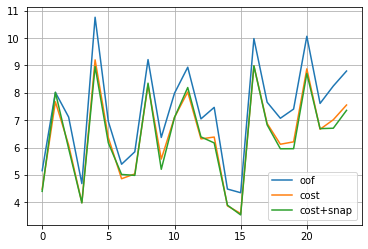

In [81]:
import matplotlib.pyplot as plt
df_result_site1['score'].plot(label='oof')
df_result_site2['score'].plot(label='cost')
df_result_site3['score'].plot(label='cost+snap')
plt.legend()
plt.grid()
plt.savefig('site_result.png')